In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [2]:
import os
import sys
sys.path.append('../src')

os.chdir('drive/My Drive')
ROOT = os.getcwd()
os.chdir(ROOT + '/Colab Notebooks')

from project_utilities.config import DATA_DIR_RAW

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from sklearn.metrics import confusion_matrix

import itertools
from project_utilities import *

#### Verify that the GPU is being utilized

In [ ]:
print(f'TensorFlow Version: {tf.__version__}')
print(f'Using CUDA: {tf.test.is_built_with_cuda()}')
print(f'Using GPU: {tf.config.list_physical_devices("GPU")}')
# print("Num of GPUs available: ", len(tf.test.gpu_device_name()))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

tf.config.experimental.set_memory_growth(physical_devices[0], True)

TensorFlow Version: 2.3.0
Using CUDA: True
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


#### Paths to the data directories

In [4]:
train_path = '../data/raw/train'
valid_path = '../data/raw/valid'
test_path = '../data/raw/test'


In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          name=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(ROOT + '/artifacts/charts/' + name + '_cm.png')

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()   

#### Wrap a Keras ImageDataGenerator

In [7]:
    
def batch_make(path, classes, batch_size=10, shuffle=True):
  batches = ImageDataGenerator(
      rescale=1./255,
        rotation_range=10,
        samplewise_center=True,
        samplewise_std_normalization=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode="nearest",
        cval=0.0,
        horizontal_flip=True).flow_from_directory(
            directory=path,
            target_size=(224,224),
            classes=classes,
            batch_size=batch_size,
            shuffle=shuffle
            )
  return batches
                       

In [ ]:
if os.path.isdir(ROOT + '/artifacts/models') is False:
    os.makedirs(ROOT + '/artifacts/models')

In [ ]:
if os.path.isdir(ROOT + '/artifacts/predictions') is False:
    os.makedirs(ROOT + '/artifacts/predictions')

#### Create datagenerators for the data

In [8]:
          
train_batch = batch_make(train_path, ['NORMAL', 'PNEUMONIA'], batch_size=20)
valid_batch = batch_make(valid_path, ['NORMAL', 'PNEUMONIA'], batch_size=20)
test_batch = batch_make(test_path, ['NORMAL', 'PNEUMONIA'], batch_size=20, shuffle=False)

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Basic CNN

In [ ]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])


#### Compile the model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#### Fit the model

In [ ]:
history_1 = model.fit(x=train_batch,
                      steps_per_epoch=len(train_batch),
                      validation_data=valid_batch,
                      validation_steps=len(valid_batch),
                      epochs=100,
                      verbose=2
                      )

Epoch 1/100
210/210 - 1532s - loss: 0.3867 - accuracy: 0.8232 - val_loss: 0.2814 - val_accuracy: 0.8701
Epoch 2/100
210/210 - 104s - loss: 0.2613 - accuracy: 0.8908 - val_loss: 0.2403 - val_accuracy: 0.9064
Epoch 3/100
210/210 - 104s - loss: 0.2472 - accuracy: 0.8906 - val_loss: 0.2281 - val_accuracy: 0.9007
Epoch 4/100
210/210 - 104s - loss: 0.2427 - accuracy: 0.8956 - val_loss: 0.2286 - val_accuracy: 0.9179
Epoch 5/100
210/210 - 103s - loss: 0.2357 - accuracy: 0.9059 - val_loss: 0.2385 - val_accuracy: 0.9121
Epoch 6/100
210/210 - 103s - loss: 0.2299 - accuracy: 0.9023 - val_loss: 0.2172 - val_accuracy: 0.9188
Epoch 7/100
210/210 - 102s - loss: 0.2078 - accuracy: 0.9147 - val_loss: 0.2030 - val_accuracy: 0.9312
Epoch 8/100
210/210 - 102s - loss: 0.2167 - accuracy: 0.9097 - val_loss: 0.2141 - val_accuracy: 0.9160
Epoch 9/100
210/210 - 102s - loss: 0.2100 - accuracy: 0.9176 - val_loss: 0.2128 - val_accuracy: 0.9188
Epoch 10/100
210/210 - 102s - loss: 0.2064 - accuracy: 0.9109 - val_loss

In [ ]:
model.save(ROOT + '/artifacts/models/basic_cnn_model.h5')

In [ ]:
model = keras.models.load_model(ROOT + '/artifacts/models/basic_cnn_model.h5')

In [ ]:
predictions = model.predict(x=test_batch, verbose=0)

In [ ]:
np.save(ROOT + '/artifacts/predictions/model_preds.py', predictions)

In [ ]:
test_batch.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[162  72]
 [ 12 378]]


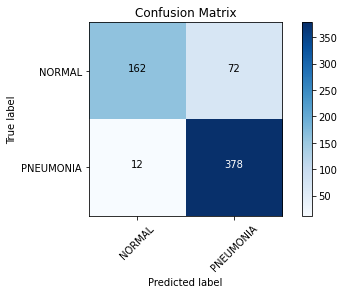

In [ ]:
cm = confusion_matrix(y_true=test_batch.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', name='basic_cnn_model')

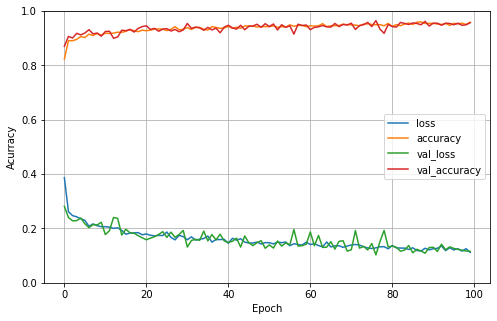

In [ ]:
pd.DataFrame(history_1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.xlabel('Epoch')
plt.ylabel('Acurracy')
plt.savefig(ROOT + '/artifacts/charts/basic_cnn_model_av.png')
plt.show()

#### Basic CNN with two addtional convolutional layers

In [9]:
model_2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])


In [10]:
model_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history_2 = model_2.fit(x=train_batch,
                        steps_per_epoch=len(train_batch),
                        validation_data=valid_batch,
                        validation_steps=len(valid_batch),
                        epochs=50,
                        verbose=2
                        )

Epoch 1/50
210/210 - 1343s - loss: 0.4894 - accuracy: 0.7649 - val_loss: 0.3502 - val_accuracy: 0.8262
Epoch 2/50
210/210 - 402s - loss: 0.3011 - accuracy: 0.8628 - val_loss: 0.3167 - val_accuracy: 0.8720
Epoch 3/50
210/210 - 402s - loss: 0.2622 - accuracy: 0.8918 - val_loss: 0.2766 - val_accuracy: 0.8835
Epoch 4/50
210/210 - 409s - loss: 0.2462 - accuracy: 0.8927 - val_loss: 0.2534 - val_accuracy: 0.8844
Epoch 5/50
210/210 - 402s - loss: 0.2403 - accuracy: 0.9001 - val_loss: 0.2617 - val_accuracy: 0.8844
Epoch 6/50
210/210 - 403s - loss: 0.2248 - accuracy: 0.9087 - val_loss: 0.2097 - val_accuracy: 0.9188
Epoch 7/50
210/210 - 402s - loss: 0.2221 - accuracy: 0.9116 - val_loss: 0.2013 - val_accuracy: 0.9245
Epoch 8/50
210/210 - 412s - loss: 0.2016 - accuracy: 0.9161 - val_loss: 0.2103 - val_accuracy: 0.9217
Epoch 9/50
210/210 - 403s - loss: 0.2033 - accuracy: 0.9185 - val_loss: 0.2179 - val_accuracy: 0.9131
Epoch 10/50
210/210 - 402s - loss: 0.2082 - accuracy: 0.9135 - val_loss: 0.1876 -

In [ ]:
#model_2 = keras.models.load_model(ROOT + '/artifacts/models/bigger_cnn_model.h5')

In [12]:
predictions_2 = model_2.predict(x=test_batch, verbose=0)

In [ ]:
np.save(ROOT + '/artifacts/predictions/model_2_preds.py', predictions_2)

In [ ]:
model_2.save(ROOT + '/artifacts/models/bigger_cnn_model.h5')

In [ ]:
test_batch.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[165  69]
 [ 12 378]]


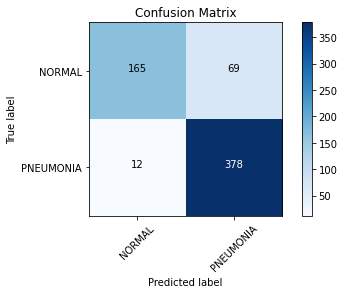

In [13]:
cm = confusion_matrix(y_true=test_batch.classes, y_pred=np.argmax(predictions_2, axis=-1))
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', name='bigger_cnn_model')

In [ ]:
print(history_2.history)

{'loss': [0.4582984149456024, 0.2957676351070404, 0.2605555057525635, 0.2519104480743408, 0.23621688783168793, 0.24180224537849426, 0.22377650439739227, 0.22648148238658905, 0.20983430743217468, 0.2173459529876709, 0.20751188695430756, 0.2068670243024826, 0.19053716957569122, 0.19553780555725098, 0.19210490584373474, 0.193191260099411, 0.1790614277124405, 0.19293822348117828, 0.178292378783226, 0.17263570427894592, 0.17348003387451172, 0.1697971522808075, 0.1752730756998062, 0.18519486486911774, 0.16445964574813843, 0.17136149108409882, 0.16545617580413818, 0.16383063793182373, 0.15592166781425476, 0.16246069967746735, 0.1523170918226242, 0.14939743280410767, 0.15271054208278656, 0.1517094373703003, 0.14688409864902496, 0.1503312736749649, 0.14813698828220367, 0.14289164543151855, 0.14550359547138214, 0.13879257440567017, 0.1434471756219864, 0.14228741824626923, 0.145168736577034, 0.1363365203142166, 0.13333438336849213, 0.13805383443832397, 0.13901051878929138, 0.1299835443496704, 0.1

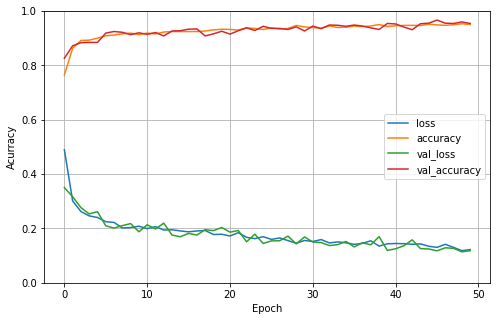

In [14]:

pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.xlabel('Epoch')
plt.ylabel('Acurracy')
plt.savefig(ROOT + '/artifacts/charts/bigger_cnn_model_av.png')
plt.show()